In [1]:
from pathlib import Path
import os

_current_fname = Path(locals()["__vsc_ipynb_file__"])
os.chdir(_current_fname.parent)

#### Automatically Generating Tomogram Masks with SAM2

In [3]:
%load_ext autoreload
%autoreload 2 

In [2]:
import matplotlib.pyplot as plt
import mrcfile, torch, copick, skimage
import my_sam2_utils as utils
from PIL import Image
import numpy as np
from tqdm import tqdm

# use bfloat16 for the entire notebook.
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


Load Copick Project

In [3]:
copick_config = (
    "/hpc/projects/group.czii/krios1.processing/copick/24jul29c/run002/copick_config.json"
)
name = "lysosome"

# Open Copick Project and Query All Available Runs
root = copick.from_file(copick_config)
run_ids = [run.name for run in root.runs]

Pull the Tomograms and labeled Points

In [76]:
runID = "Position_34_2_Vol"

# Get Run
run = root.get_run(runID)

# Get Tomogram
vol = utils.get_tomogram(run)
membranes = utils.get_membrane(run)

# Get Lysosome Centers
# points = utils.get_coordinates(run)

Getting denoised Tomogram with 10 A voxel size for the associated runID: Position_34_2_Vol
Getting denoised Tomogram with 10 A voxel size for the associated runID: Position_34_2_Vol


#### Option1 : Automatic Mask Generator (Pointless Annotation)

In [77]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = (
    "/hpc/mydata/saugat.kandel/sam2_projects/segment-anything-2/checkpoints/sam2_hiera_large.pt"
)
model_cfg = "sam2_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=True)
# mask_generator = SAM2AutomaticMaskGenerator(sam2)
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=2000,
    use_m2m=True,
)

In [78]:
volNorm = vol.copy()
volNorm = (vol - vol.min()) / (vol.max() - vol.min())
volNorm = volNorm * 2 - 1

In [79]:
vol.shape

(186, 632, 632)

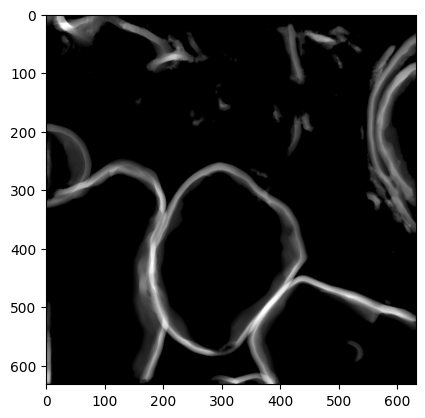

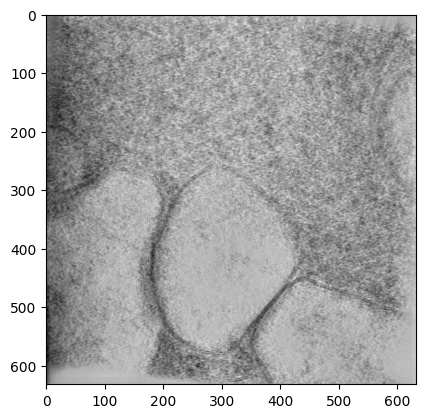

In [82]:
zSlice = 90  # int(points.mean(axis=0)[0])
deltaZ = 50  # int((np.max(points[:, 0]) - np.min(points[:, 0]))) * 2
imScale = 1

min_mask_area = 2000

membrane_proj = utils.project_tomogram(membranes, zSlice, deltaZ)
plt.imshow(membrane_proj, cmap="gray")
plt.show()
#
image = utils.project_tomogram(volNorm, zSlice, deltaZ)
plt.imshow(image, cmap="gray")

In [83]:
# Extend From Grayscale to RGB
# image = np.repeat(image[..., None], 3, axis=2)
# image[..., 0] += 0.2 * membrane_proj

(632, 632, 3)
Total # of Available Masks:  4
Keys within a Mask:  dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


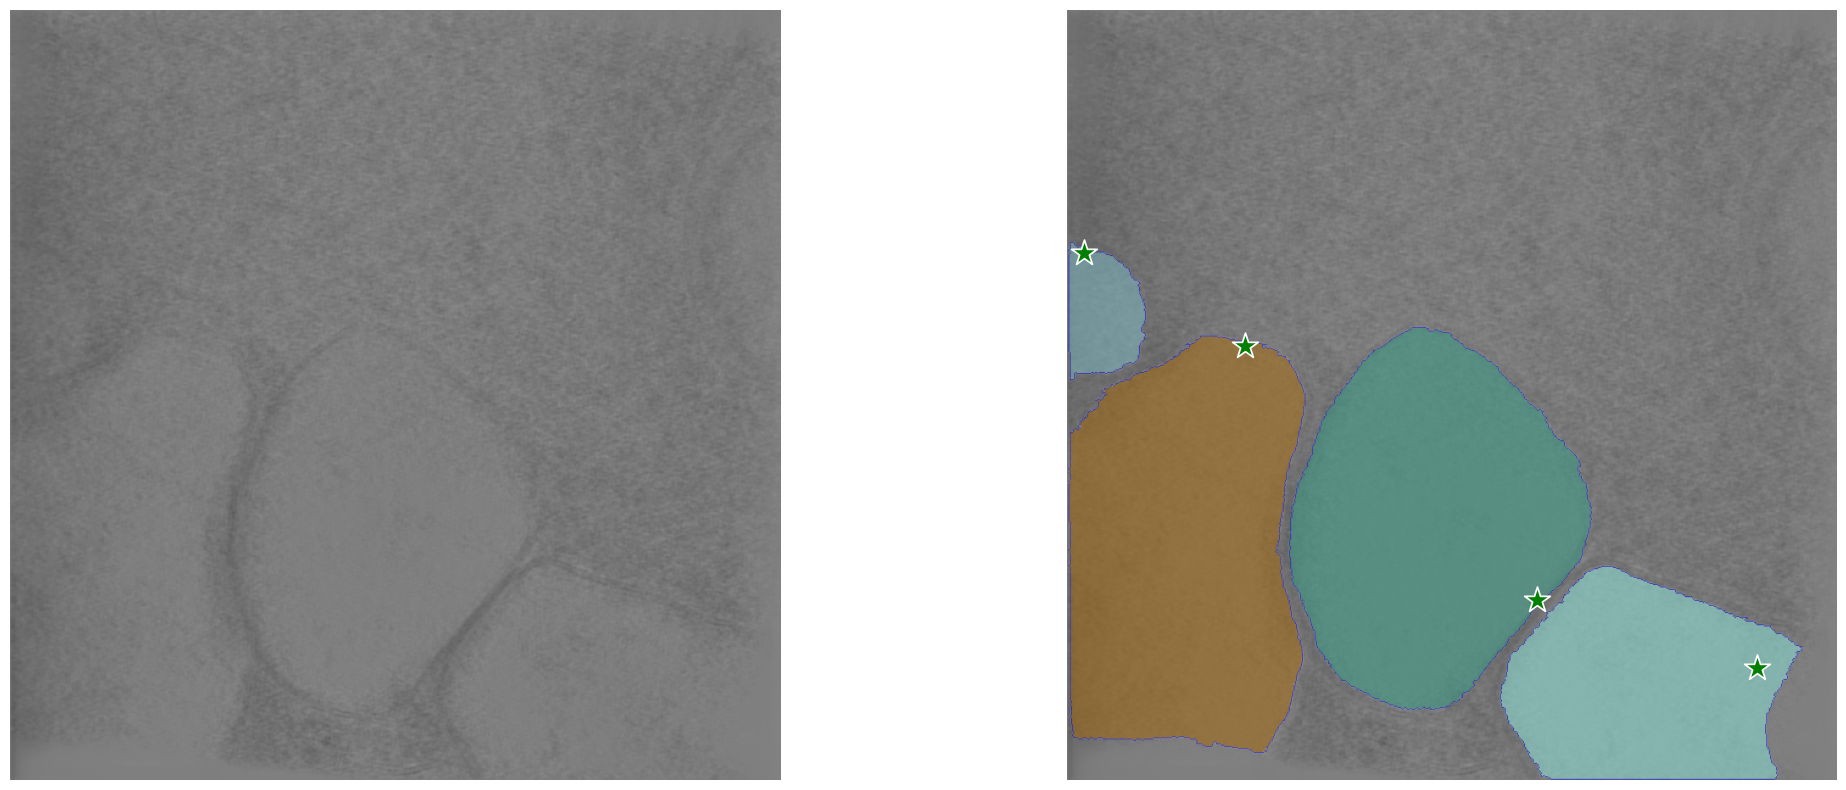

In [85]:
# Extend From Grayscale to RGB
image = np.repeat(image[..., None], 3, axis=2)

print(image.shape)
# Run Inference from Pre-trained Model
masks = mask_generator.generate(image)

# Filter masks based on the area key
masks = [mask for mask in masks if mask["area"] >= min_mask_area]

print("Total # of Available Masks: ", len(masks))
print("Keys within a Mask: ", masks[0].keys())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
ax1.imshow(image, cmap="gray")
ax1.axis("off")
# Extract all 'point_coords'
auto_points = np.array([item["point_coords"] for item in masks])

# Reshape the array to (N, 2)
auto_points = auto_points.reshape(-1, 2)

labels = np.ones(auto_points.shape[0])
utils.show_points(auto_points, labels, plt.gca())
# ss = ax1.scatter(points[:,2], points[:,1], marker='*', c='g',  edgecolor='white', s=500)
# ax1.legend([],['Lysosome'],fontsize='15')

ax2.imshow(image, cmap="gray")
ax1.axis("off")
utils.show_anns(masks)
plt.axis("off")
plt.show()

315.91296269700615 0.9812199008181607 0.6336986180834108 0.7494902029586095 54808.0 0.698769681902212


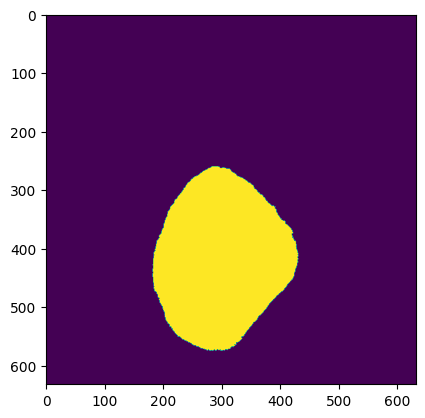

253.39692184397188 0.9512043924902586 0.6842112775665986 0.6463500429185307 32223.0 0.7352820372398685


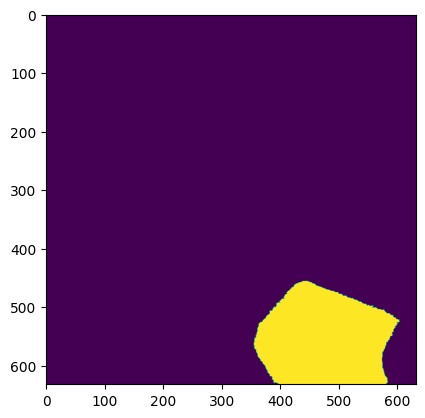

360.5440333717922 0.9387396351575457 0.8271783716635172 0.5968100775789793 56606.0 0.8463183075427974


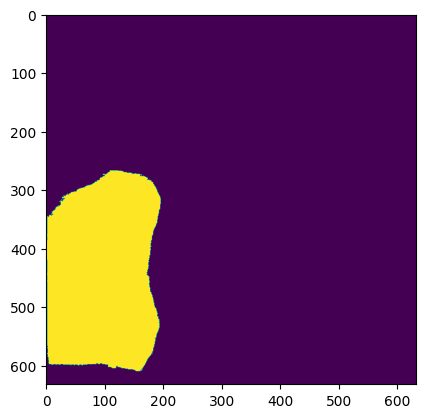

115.06954418958998 0.9547814436442806 0.7901791716439527 0.6055236429699307 5701.0 0.7745923913043479


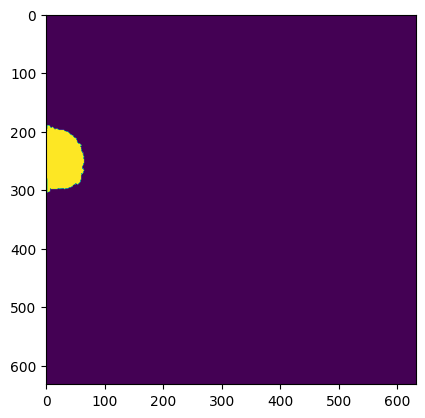

In [86]:
for mask in masks:
    rprops = skimage.measure.regionprops(mask["segmentation"].astype("int"))
    circularity = 4 * np.pi * rprops[0].area / (rprops[0].perimeter ** 2)
    print(
        rprops[0].feret_diameter_max,
        rprops[0].solidity,
        rprops[0].eccentricity,
        circularity,
        rprops[0].area,
        rprops[0].extent,
    )
    plt.imshow(mask["segmentation"])
    plt.show()

#### Option2: Video Segmentation

In [87]:
from sam2.build_sam import build_sam2_tomogram_predictor

sam2_checkpoint = (
    "/hpc/mydata/saugat.kandel/sam2_projects/segment-anything-2/checkpoints/sam2_hiera_large.pt"
)
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_tomogram_predictor(model_cfg, sam2_checkpoint, device=device)

inference_state = predictor.init_state(vol)

100%|██████████| 186/186 [00:04<00:00, 38.25it/s]


In [88]:
predictor.reset_state(inference_state)

/hpc/mydata/saugat.kandel/sam2_projects/segment-anything-2/notebooks/my_sam2_utils.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame = torch.tensor(tomo[frame_id], device="cpu")


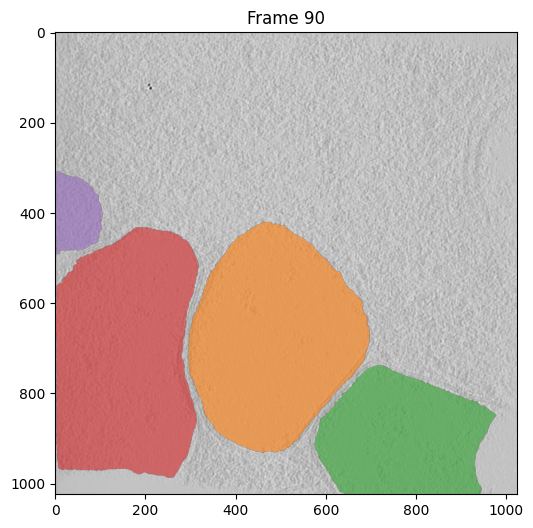

In [89]:
prompts = {}
ann_frame_idx = (
    90  # int(points.mean(axis=0)[0])  # int(points[0][0])  # the frame index we interact with
)
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
scale = predictor.image_size / vol.shape[1]
labels = np.array([1], np.int32)


for ii in range(len(masks)):
    # sam_points = (auto_points[ii, :] * scale).reshape(1, 2)
    ann_obj_id = ii + 1

    # _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    #    inference_state=inference_state,
    #    frame_idx=ann_frame_idx,
    #    obj_id=ann_obj_id,
    #    points=sam_points,
    #    labels=labels,
    # )
    _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        mask=masks[ii]["segmentation"],
    )
    prompts.setdefault(ann_obj_id, {})
    prompts[ann_obj_id].setdefault(ann_frame_idx, [])
    prompts[ann_obj_id][ann_frame_idx].append((masks[ii], labels))

    # show the results on the current (interacted) frame
    if ii == 0:
        plt.figure(figsize=(9, 6))
        plt.title(f"frame {ann_frame_idx}")
        utils.show_tomo_frame(inference_state["images"], ann_frame_idx, plt.gca())

        # utils.show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

for i, out_obj_id in enumerate(out_obj_ids):
    utils.show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

labels = np.ones(auto_points.shape[0])
# utils.show_points(auto_points * scale, labels, plt.gca())

propagate in video:   0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 91/91 [00:01<00:00, 65.80it/s]


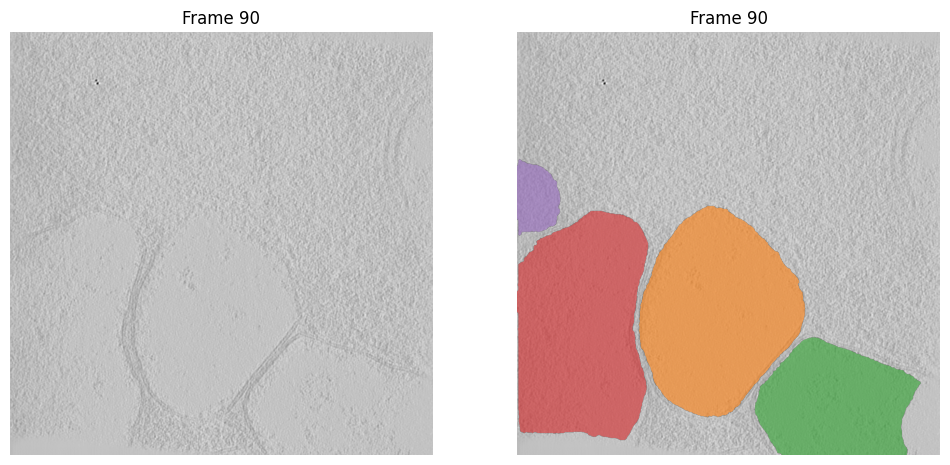

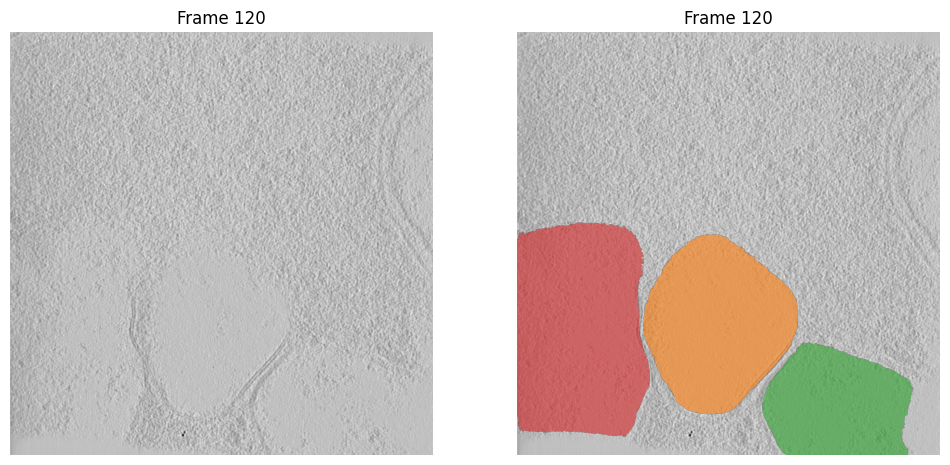

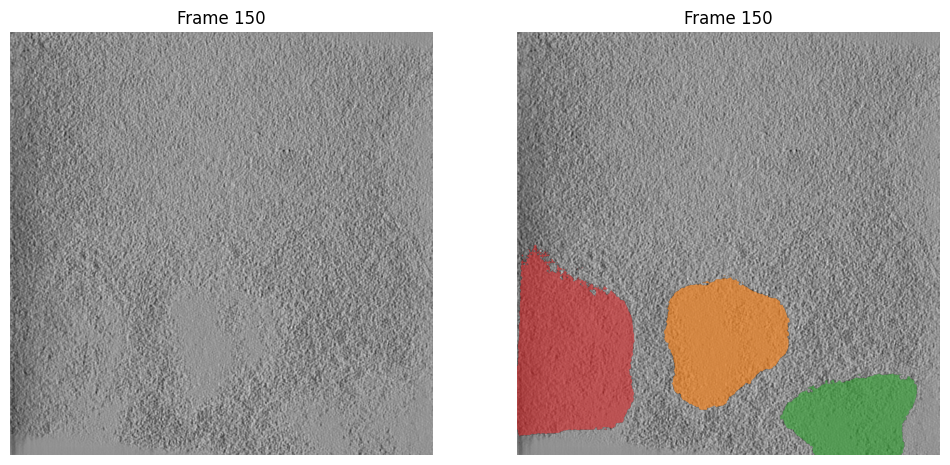

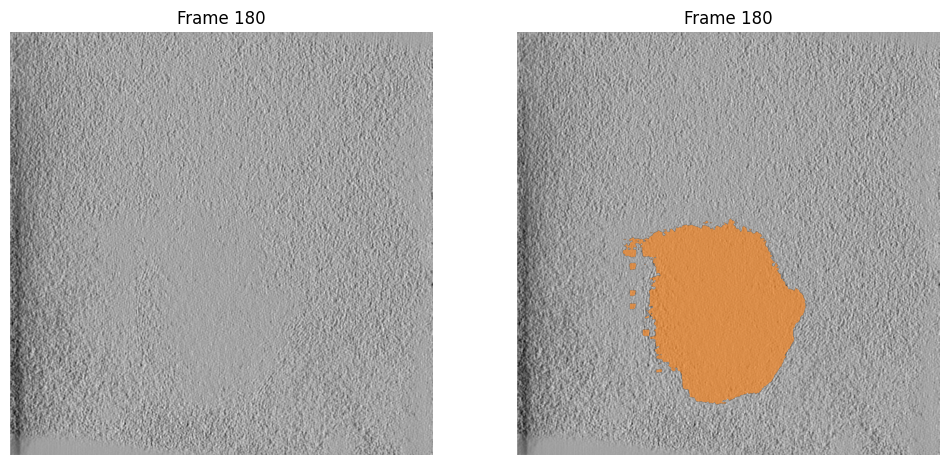

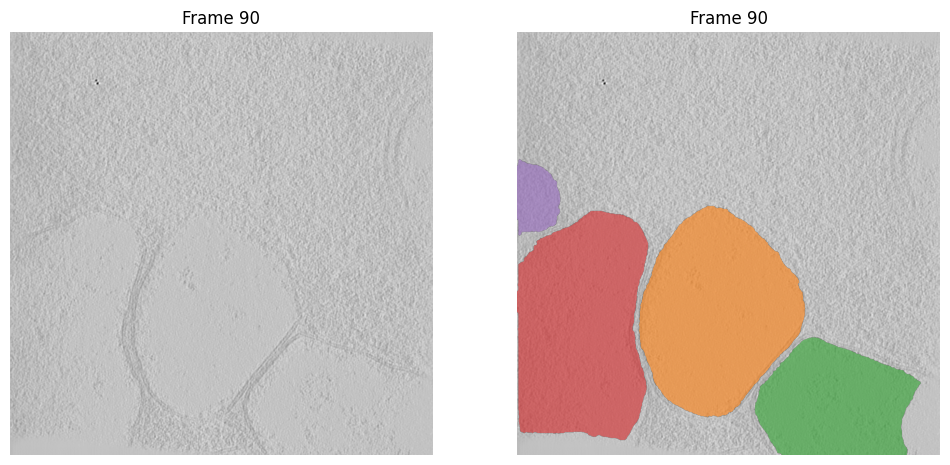

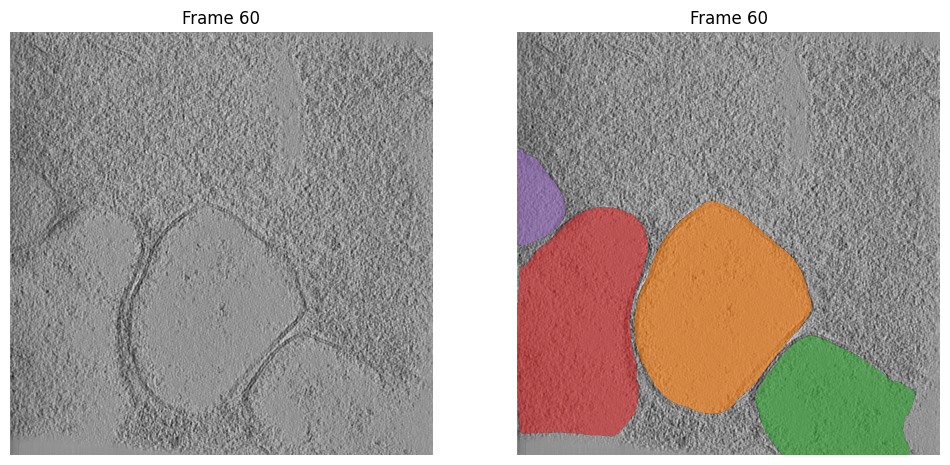

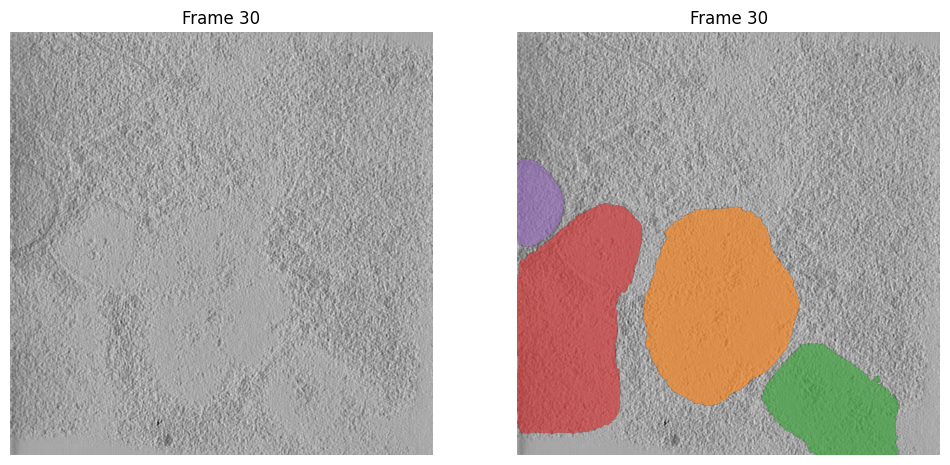

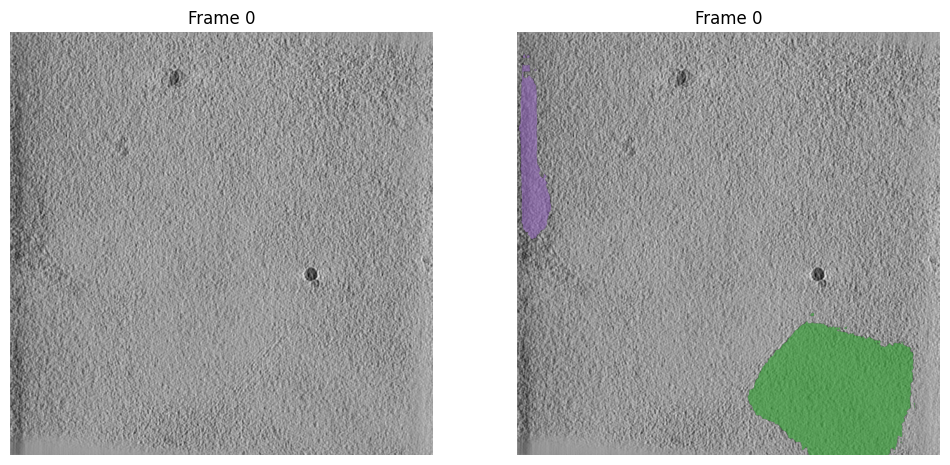

In [90]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(
    inference_state, start_frame_idx=90, reverse=False
):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in list(video_segments)[::vis_frame_stride]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image, cmap="gray")
    ax1.axis("off")
    ax1.set_title(f"frame {out_frame_idx}")
    utils.show_tomo_frame(inference_state["images"], out_frame_idx, ax1)
    utils.show_tomo_frame(inference_state["images"], out_frame_idx, ax2)
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        utils.show_mask(out_mask, ax2, obj_id=out_obj_id)
        ax2.axis("off")

# Pull out Masks for Multiple Classes
nMasks = len(video_segments[90])
vol_mask = np.zeros([vol.shape[0], vol.shape[1], vol.shape[2]], dtype=np.uint8)
for out_frame_idx in tqdm(list(video_segments)):
    for jj in range(nMasks):
        resized_mask = skimage.transform.resize(
            video_segments[out_frame_idx][jj + 1][0,],
            (vol.shape[1], vol.shape[2]),
            anti_aliasing=False,
        )
        mask_update = resized_mask > 0
        vol_mask[out_frame_idx, :, :][mask_update] = jj

# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(
    inference_state, start_frame_idx=90, reverse=True
):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# # render the segmentation results every few frames
vis_frame_stride = 30
# plt.close("all")
for out_frame_idx in list(video_segments)[::vis_frame_stride]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image, cmap="gray")
    ax1.axis("off")
    ax1.set_title(f"frame {out_frame_idx}")
    utils.show_tomo_frame(inference_state["images"], out_frame_idx, ax1)
    utils.show_tomo_frame(inference_state["images"], out_frame_idx, ax2)
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        utils.show_mask(out_mask, ax2, obj_id=out_obj_id)
        ax2.axis("off")

# Pull out Masks for Multiple Classes
for out_frame_idx in tqdm(list(video_segments)):
    for jj in range(nMasks):
        resized_mask = skimage.transform.resize(
            video_segments[out_frame_idx][jj + 1][0,],
            (vol.shape[1], vol.shape[2]),
            anti_aliasing=False,
        )
        mask_update = resized_mask > 0
        vol_mask[out_frame_idx, :, :][mask_update] = jj

##### Option 1: Save Segmentation as MRC

In [23]:
# Write the volume to an MRC file
with mrcfile.new("output.mrc", overwrite=True) as mrc:
    mrc.set_data(vol_mask)
    mrc.voxel_size = 10.0  # Set voxel size if required, e.g., in Angstroms
    mrc.update_header_from_data()  # Optionally update the header

##### Option 2: Export Segmentation into Copick Project

In [19]:
utils.write_ome_zarr_segmentation(
    run,
    vol_mask,
    voxelSize=10,
    segmentationName="organelles",
    userID="sam2",
    sessionID="1",
    multilabel_seg=True,
)